# DINOv3 Feature Extraction: Unified Analysis

This notebook provides a flexible feature extraction and analysis framework for DINOv3 models:
- **Support for multiple dataset types**: Custom datasets, HuggingFace datasets
- **Dual model comparison**: Original pretrained vs fine-tuned models
- **Comprehensive analysis**: PCA, t-SNE, UMAP visualizations
- **Statistical comparisons**: Feature distributions and similarity metrics
- **Professional visualizations**: Publication-quality plots with custom styling

**Simply configure the dataset type and paths below to get started!**

In [1]:
# Import libraries and setup
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

# Dimensionality reduction and analysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.metrics.pairwise import cosine_similarity

# Setup paths for notebooks directory
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)
dinov3_path = os.path.join(project_root, "dinov3")
sys.path.insert(0, dinov3_path)

# Import custom modules
from data.custom_dataset import CustomImageDataset
from data.huggingface_dataset import HuggingFaceDataset
from src.models.dinov3_lightning_model import DINOv3LightningModule

# Enhanced plotting style
plt.style.use('default')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# Color scheme
COLORS = {
    'original': '#2E86AB',      # Blue
    'finetuned': '#A23B72',     # Magenta  
    'accent': '#F18F01',        # Orange
    'text': '#333333'
}

print("✓ Libraries imported and styling configured")

/home/marjans/anaconda3/envs/dlv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.8.0 available.


✓ Libraries imported and styling configured


## 📊 Configuration and Dataset Selection

**Choose your dataset type and configure paths:**
- Set `DATASET_TYPE` to either `"custom"` or `"huggingface"`
- Configure the appropriate dataset parameters below

In [2]:
# ============================================================================
# MAIN CONFIGURATION - EDIT THESE SETTINGS
# ============================================================================

# Dataset Configuration - Choose one:
DATASET_TYPE = "huggingface"  # Options: "custom", "huggingface"

# Custom Dataset Settings (used if DATASET_TYPE == "custom")
CUSTOM_DATASET_PATH = '../../Datasets/composite/'

# HuggingFace Dataset Settings (used if DATASET_TYPE == "huggingface")
HF_DATASET_NAME = 'jonathancui/oxford-pets'
HF_SPLIT = None  # None for all splits, or specify 'train', 'test', etc.
HF_IMAGE_KEY = 'image'  # Column name containing images
HF_LABEL_KEY = 'label'  # Column name containing labels

# ============================================================================
# SYSTEM CONFIGURATION
# ============================================================================

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

# Model paths
ORIGINAL_MODEL_PATH = os.path.join(project_root, 'dinov3_official_weights', 'dinov3_vits16_pretrain_lvd1689m-08c60483.pth')
FINETUNED_CHECKPOINT = os.path.join(project_root, 'output_hf', 'checkpoints', 'last.ckpt')
CONFIG_FILE = os.path.join(project_root, 'configs', 'config_lightning_finetuning_v2.yaml')

# Analysis parameters
OUTPUT_DIR = Path('./feature_analysis_unified_results')
OUTPUT_DIR.mkdir(exist_ok=True)

BATCH_SIZE = 16
MAX_SAMPLES = 7349  # Maximum number of samples to process
RANDOM_SEED = 42

# Dimensionality reduction parameters  
PCA_COMPONENTS = 50
TSNE_PERPLEXITY = 30
UMAP_NEIGHBORS = 15

# Set random seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"✓ Configuration set:")
print(f"  - Dataset type: {DATASET_TYPE}")
if DATASET_TYPE == "custom":
    print(f"  - Custom dataset path: {CUSTOM_DATASET_PATH}")
else:
    print(f"  - HuggingFace dataset: {HF_DATASET_NAME}")
print(f"  - Max samples: {MAX_SAMPLES}")
print(f"  - Output dir: {OUTPUT_DIR}")
print(f"  - Original model available: {os.path.exists(ORIGINAL_MODEL_PATH)}")
print(f"  - Fine-tuned model available: {os.path.exists(FINETUNED_CHECKPOINT)}")
print(f"  - Config file available: {os.path.exists(CONFIG_FILE)}")

Device: cuda
✓ Configuration set:
  - Dataset type: huggingface
  - HuggingFace dataset: jonathancui/oxford-pets
  - Max samples: 7349
  - Output dir: feature_analysis_unified_results
  - Original model available: True
  - Fine-tuned model available: True
  - Config file available: True


## 🤖 Model Loading Functions

In [3]:
def load_original_model():
    """Load original pretrained DINOv3 model using torch.hub with local weights"""
    try:
        print("Loading original DINOv3 model via torch.hub...")
        
        dinov3_hub_path = os.path.join(project_root, 'dinov3')
        model = torch.hub.load(
            dinov3_hub_path, 
            'dinov3_vits16', 
            source='local',
            weights=ORIGINAL_MODEL_PATH,
            pretrained=True
        )
        model.to(DEVICE)
        model.eval()
        
        print("✓ Original model loaded successfully via torch.hub")
        return model
        
    except Exception as e:
        print(f"✗ Failed to load original model: {e}")
        return None

def load_finetuned_model():
    """Load fine-tuned DINOv3 Lightning model"""
    try:
        print("Loading fine-tuned DINOv3 model...")
        
        lightning_model = DINOv3LightningModule.load_from_checkpoint(
            FINETUNED_CHECKPOINT,
            cfg_path=CONFIG_FILE,
            map_location=DEVICE,
            strict=True
        )
        
        model = lightning_model.ssl_model.teacher.backbone
        model.eval()
        
        print("✓ Fine-tuned model loaded successfully")
        return model
        
    except Exception as e:
        print(f"✗ Failed to load fine-tuned model: {e}")
        return None

def extract_features(model, dataloader, model_name):
    """Extract CLS token features from model"""
    features = []
    
    print(f"Extracting features from {model_name} model...")
    
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc=f"Processing {model_name}"):
            images = images.to(DEVICE)
            
            # Forward pass to get features
            outputs = model(images)
            
            # Extract CLS token features
            if hasattr(outputs, 'shape') and len(outputs.shape) == 2:
                cls_features = outputs
            else:
                cls_features = outputs[:, 0] if len(outputs.shape) > 2 else outputs
                
            features.append(cls_features.cpu().numpy())
    
    features = np.vstack(features)
    print(f"✓ {model_name} features extracted: {features.shape}")
    return features

## 📊 Dataset Loading and Preparation

In [4]:
# Load models first
print("=" * 60)
print("LOADING MODELS")
print("=" * 60)

original_model = load_original_model()
finetuned_model = load_finetuned_model()

models_loaded = {
    'original': original_model is not None,
    'finetuned': finetuned_model is not None
}

print(f"\nModel loading status:")
for name, status in models_loaded.items():
    print(f"  {name}: {'✓' if status else '✗'}")

# Prepare dataset based on type
print("\n" + "=" * 60)
print("LOADING DATASET")
print("=" * 60)

# Common transform - Fixed to match original working implementation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if DATASET_TYPE == "custom":
    print(f"Loading custom dataset from: {CUSTOM_DATASET_PATH}")
    
    dataset = CustomImageDataset(root=CUSTOM_DATASET_PATH, transform=transform, recursive=True)
    print(f"Custom dataset loaded: {len(dataset)} images")
    
    # Extract cell names for custom dataset (like in the original custom notebook)
    cell_names = []
    image_paths = dataset.image_paths
    for image_path in image_paths:
        fname = Path(image_path).stem
        cell_name = "_".join(fname.split("_")[3:])
        cell_names.append(cell_name)
    
    unique_cells = sorted(set(cell_names))
    
    # Create color mapping for custom dataset
    try:
        import colorcet as cc
        cmap = cc.glasbey
        colors = [cmap[i % len(cmap)] for i in range(len(unique_cells))]
    except:
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_cells)))
    
    label_mapping = dict(zip(unique_cells, colors))
    dataset_name = "Custom Dataset"
    
elif DATASET_TYPE == "huggingface":
    print(f"Loading HuggingFace dataset: {HF_DATASET_NAME}")
    
    dataset = HuggingFaceDataset(
        name=HF_DATASET_NAME,
        split=HF_SPLIT,
        transform=transform,
        image_key=HF_IMAGE_KEY,
        label_key=HF_LABEL_KEY,
        streaming=False
    )
    print(f"HuggingFace dataset loaded: {len(dataset)} samples")
    
    # Extract label information for HuggingFace dataset
    hf_dataset = dataset.dataset
    label_feature = hf_dataset.features[HF_LABEL_KEY]
    label_names = {i: name for i, name in enumerate(label_feature.names)}
    unique_labels = list(range(len(label_feature.names)))
    
    # Create color mapping for HuggingFace dataset
    if len(unique_labels) <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    else:
        try:
            import colorcet as cc
            cmap = cc.glasbey
            colors = [cmap[i % len(cmap)] for i in range(len(unique_labels))]
        except:
            colors = plt.cm.hsv(np.linspace(0, 1, len(unique_labels)))
    
    label_mapping = dict(zip(unique_labels, colors))
    dataset_name = HF_DATASET_NAME
    
    print(f"Found {len(unique_labels)} classes: {list(label_names.values())[:5]}{'...' if len(unique_labels) > 5 else ''}")

else:
    raise ValueError(f"Unknown dataset type: {DATASET_TYPE}. Use 'custom' or 'huggingface'")

# Limit samples for analysis
if len(dataset) > MAX_SAMPLES:
    indices = torch.randperm(len(dataset))[:MAX_SAMPLES]
    dataset = torch.utils.data.Subset(dataset, indices)
    print(f"Using {len(dataset)} samples for analysis")

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
print(f"✓ DataLoader ready: {len(dataloader)} batches")

# Extract labels for visualization
print("\nExtracting labels for visualization...")
all_labels = []
with torch.no_grad():
    for _, labels_batch in tqdm(dataloader, desc="Getting labels"):
        if DATASET_TYPE == "custom":
            # For custom dataset, we need to map to cell names
            all_labels.extend([0] * len(labels_batch))  # Simplified for now
        else:
            # For HuggingFace, use the actual labels
            all_labels.extend(labels_batch.numpy())

print(f"✓ Labels extracted: {len(all_labels)} samples")

INFO:dinov3:using base=100 for rope new
INFO:dinov3:using min_period=None for rope new
INFO:dinov3:using max_period=None for rope new
INFO:dinov3:using normalize_coords=separate for rope new
INFO:dinov3:using shift_coords=None for rope new
INFO:dinov3:using rescale_coords=2 for rope new
INFO:dinov3:using jitter_coords=None for rope new
INFO:dinov3:using dtype=fp32 for rope new
INFO:dinov3:using mlp layer as FFN


LOADING MODELS
Loading original DINOv3 model via torch.hub...
✓ Original model loaded successfully via torch.hub
Loading fine-tuned DINOv3 model...


INFO:dinov3_lightning:Building DINOv3 SSL model...
INFO:dinov3:using base=100.0 for rope new
INFO:dinov3:using min_period=None for rope new
INFO:dinov3:using max_period=None for rope new
INFO:dinov3:using normalize_coords=separate for rope new
INFO:dinov3:using shift_coords=None for rope new
INFO:dinov3:using rescale_coords=None for rope new
INFO:dinov3:using jitter_coords=None for rope new
INFO:dinov3:using dtype=bf16 for rope new
INFO:dinov3:using mlp layer as FFN
INFO:dinov3:fp8 matmuls: OFF (disabled in config)
INFO:dinov3:using base=100.0 for rope new
INFO:dinov3:using min_period=None for rope new
INFO:dinov3:using max_period=None for rope new
INFO:dinov3:using normalize_coords=separate for rope new
INFO:dinov3:using shift_coords=None for rope new
INFO:dinov3:using rescale_coords=None for rope new
INFO:dinov3:using jitter_coords=None for rope new
INFO:dinov3:using dtype=bf16 for rope new
INFO:dinov3:using mlp layer as FFN
INFO:dinov3:fp8 matmuls: OFF (disabled in config)
INFO:dino

✓ Fine-tuned model loaded successfully

Model loading status:
  original: ✓
  finetuned: ✓

LOADING DATASET
Loading HuggingFace dataset: jonathancui/oxford-pets


INFO:dinov3:Available splits: ['train', 'test']
INFO:dinov3:Concatenated 2 splits: ['train', 'test']
INFO:dinov3:Dataset columns: ['image', 'label']
INFO:dinov3:Dataset size: 7,349 samples


HuggingFace dataset loaded: 7349 samples
Found 37 classes: ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair']...
✓ DataLoader ready: 460 batches

Extracting labels for visualization...


Getting labels: 100%|██████████| 460/460 [00:08<00:00, 52.76it/s]

✓ Labels extracted: 7349 samples


## 🔍 Feature Extraction and Analysis

In [5]:
# Extract features from both models
print("=" * 60)
print("FEATURE EXTRACTION")
print("=" * 60)

features = {}

# Extract from original model
if models_loaded['original']:
    features['original'] = extract_features(original_model, dataloader, 'Original')
else:
    print("✗ Skipping original model - not loaded")

# Extract from fine-tuned model  
if models_loaded['finetuned']:
    features['finetuned'] = extract_features(finetuned_model, dataloader, 'Fine-tuned')
else:
    print("✗ Skipping fine-tuned model - not loaded")

print(f"\nFeature extraction summary:")
for name, feats in features.items():
    print(f"  {name}: {feats.shape}")

def analyze_features(feats, name):
    """Analyze feature statistics"""
    return {
        'name': name,
        'shape': feats.shape,
        'mean': float(np.mean(feats)),
        'std': float(np.std(feats)),
        'norm_mean': float(np.mean(np.linalg.norm(feats, axis=1))),
        'norm_std': float(np.std(np.linalg.norm(feats, axis=1)))
    }

# Analyze features
stats = {}
for name, feats in features.items():
    stats[name] = analyze_features(feats, name)
    print(f"\n{name.title()} features:")
    for key, value in stats[name].items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")

FEATURE EXTRACTION
Extracting features from Original model...


Processing Original: 100%|██████████| 460/460 [00:09<00:00, 49.48it/s]


✓ Original features extracted: (7349, 384)
Extracting features from Fine-tuned model...


Processing Fine-tuned: 100%|██████████| 460/460 [00:09<00:00, 50.01it/s]


✓ Fine-tuned features extracted: (7349, 384)

Feature extraction summary:
  original: (7349, 384)
  finetuned: (7349, 384)

Original features:
  name: original
  shape: (7349, 384)
  mean: 0.0007
  std: 0.4713
  norm_mean: 9.2313
  norm_std: 0.2620

Finetuned features:
  name: finetuned
  shape: (7349, 384)
  mean: -0.0013
  std: 0.5183
  norm_mean: 10.1537
  norm_std: 0.2649


## 📈 Dimensionality Reduction

In [6]:
# Dimensionality reduction for visualization
print("=" * 60)
print("DIMENSIONALITY REDUCTION")
print("=" * 60)

def apply_pca(feats, name, n_components=None):
    """Apply PCA to features"""
    if n_components is None:
        n_components = min(PCA_COMPONENTS, feats.shape[0], feats.shape[1])
    
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    feats_pca = pca.fit_transform(feats)
    explained_var = pca.explained_variance_ratio_
    
    print(f"✓ {name} PCA: {n_components} components, {np.sum(explained_var):.3f} variance explained")
    return feats_pca, explained_var

def apply_tsne(feats, name):
    """Apply t-SNE to features"""
    if feats.shape[1] > 50:
        pca_temp = PCA(n_components=50, random_state=RANDOM_SEED)
        feats_reduced = pca_temp.fit_transform(feats)
    else:
        feats_reduced = feats
    
    perplexity = min(TSNE_PERPLEXITY, (feats.shape[0] - 1) // 3)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=RANDOM_SEED, n_jobs=-1)
    feats_tsne = tsne.fit_transform(feats_reduced)
    
    print(f"✓ {name} t-SNE: perplexity={perplexity}")
    return feats_tsne

def apply_umap(feats, name):
    """Apply UMAP to features"""
    n_neighbors = min(UMAP_NEIGHBORS, feats.shape[0] - 1)
    mapper = umap.UMAP(n_components=2, n_neighbors=n_neighbors, random_state=RANDOM_SEED)
    feats_umap = mapper.fit_transform(feats)
    
    print(f"✓ {name} UMAP: n_neighbors={n_neighbors}")
    return feats_umap

# Apply dimensionality reduction to all feature sets
embeddings = {}
explained_variance = {}

for name, feats in features.items():
    print(f"\nProcessing {name} features...")
    embeddings[name] = {}
    
    # PCA
    pca_result, exp_var = apply_pca(feats, name)
    embeddings[name]['pca'] = pca_result
    explained_variance[name] = exp_var
    
    # t-SNE
    embeddings[name]['tsne'] = apply_tsne(feats, name)
    
    # UMAP
    embeddings[name]['umap'] = apply_umap(feats, name)

print(f"\n✓ All dimensionality reductions completed!")

DIMENSIONALITY REDUCTION

Processing original features...
✓ original PCA: 50 components, 0.741 variance explained
✓ original t-SNE: perplexity=30
✓ original UMAP: n_neighbors=15

Processing finetuned features...
✓ finetuned PCA: 50 components, 0.693 variance explained
✓ finetuned t-SNE: perplexity=30
✓ finetuned UMAP: n_neighbors=15

✓ All dimensionality reductions completed!


## 🎨 Visualization Functions

In [7]:
def plot_comparison(embeddings, method, explained_variance=None):
    """Create side-by-side comparison plots with label coloring"""
    n_models = len(embeddings)
    fig, axes = plt.subplots(1, n_models, figsize=(8*n_models, 6))
    
    if n_models == 1:
        axes = [axes]
    
    fig.suptitle(f'DINOv3 Feature Visualization on {dataset_name}: {method.upper()}', 
                 fontsize=18, fontweight='bold', y=0.95)
    
    for i, (name, data) in enumerate(embeddings.items()):
        ax = axes[i]
        
        # Get colors for data points based on dataset type
        if DATASET_TYPE == "custom":
            # For custom dataset, use cell names
            if isinstance(dataset, torch.utils.data.Subset):
                subset_indices = dataset.indices[:len(data)]
                current_cell_names = [cell_names[idx] for idx in subset_indices]
            else:
                current_cell_names = cell_names[:len(data)]
            point_colors = [label_mapping[cell] for cell in current_cell_names]
        else:
            # For HuggingFace dataset, use class labels
            current_labels = all_labels[:len(data)]
            point_colors = [label_mapping[label] for label in current_labels]
        
        # Create scatter plot
        scatter = ax.scatter(data[:, 0], data[:, 1], 
                           c=point_colors, alpha=0.7, s=25, 
                           edgecolors='white', linewidth=0.3)
        
        # Set title
        model_title = 'Original Pretrained' if name == 'original' else 'Fine-tuned'
        ax.set_title(f'{model_title}', fontsize=15, fontweight='bold', pad=15)
        
        # Set axis labels
        if method.lower() == 'pca' and explained_variance and name in explained_variance:
            exp_var = explained_variance[name]
            ax.set_xlabel(f'PC1 ({exp_var[0]:.1%} variance)', fontsize=12)
            ax.set_ylabel(f'PC2 ({exp_var[1]:.1%} variance)', fontsize=12)
        else:
            ax.set_xlabel(f'{method.upper()}-1', fontsize=12)
            ax.set_ylabel(f'{method.upper()}-2', fontsize=12)
        
        # Styling
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_facecolor('#fafafa')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#cccccc')
        ax.spines['bottom'].set_color('#cccccc')
    
    # Add legend (limited for readability)
    # if len(label_mapping) <= 20:  # Only show legend if not too many labels
    if DATASET_TYPE == "custom":
        legend_items = [(cell.replace('_', ' '), color) for cell, color in label_mapping.items()]
        legend_title = "Cell Types"
    else:
        legend_items = [(label_names[label], color) for label, color in label_mapping.items()]
        legend_title = "Classes"
        
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=name,
                            markerfacecolor=color, markersize=8, markeredgecolor='white')
                for name, color in legend_items]
    fig.legend(handles=handles, title=legend_title, 
                bbox_to_anchor=(1.02, 0.5), loc='center left',
                fontsize=10, title_fontsize=11)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'{method}_comparison.png', dpi=300, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

def plot_feature_distributions():
    """Plot feature distribution comparisons"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Feature Distribution Comparison: Original vs Fine-tuned', 
                 fontsize=16, fontweight='bold', y=0.99)
    
    # Feature norms
    ax = axes[0, 0]
    for name, feats in features.items():
        norms = np.linalg.norm(feats, axis=1)
        color = COLORS['original'] if name == 'original' else COLORS['finetuned']
        label = 'Original' if name == 'original' else 'Fine-tuned'
        
        ax.hist(norms, bins=40, alpha=0.7, color=color, label=label, 
                density=True, edgecolor='white', linewidth=0.5)
    
    ax.set_xlabel('Feature Norm', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Feature Norm Distribution', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#fafafa')
    
    # Feature means
    ax = axes[0, 1]
    for name, feats in features.items():
        means = np.mean(feats, axis=1)
        color = COLORS['original'] if name == 'original' else COLORS['finetuned']
        label = 'Original' if name == 'original' else 'Fine-tuned'
        
        ax.hist(means, bins=40, alpha=0.7, color=color, label=label,
                density=True, edgecolor='white', linewidth=0.5)
    
    ax.set_xlabel('Feature Mean', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Feature Mean Distribution', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#fafafa')
    
    # Feature standard deviations
    ax = axes[1, 0]
    for name, feats in features.items():
        stds = np.std(feats, axis=1)
        color = COLORS['original'] if name == 'original' else COLORS['finetuned']
        label = 'Original' if name == 'original' else 'Fine-tuned'
        
        ax.hist(stds, bins=40, alpha=0.7, color=color, label=label,
                density=True, edgecolor='white', linewidth=0.5)
    
    ax.set_xlabel('Feature Std Dev', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Feature Standard Deviation', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#fafafa')
    
    # First principal component
    ax = axes[1, 1]
    for name in embeddings.keys():
        if 'pca' in embeddings[name]:
            pc1 = embeddings[name]['pca'][:, 0]
            color = COLORS['original'] if name == 'original' else COLORS['finetuned']
            label = 'Original' if name == 'original' else 'Fine-tuned'
            
            ax.hist(pc1, bins=40, alpha=0.7, color=color, label=label,
                    density=True, edgecolor='white', linewidth=0.5)
    
    ax.set_xlabel('First Principal Component', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('PC1 Distribution', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#fafafa')
    
    # Style all axes
    for ax in axes.flat:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#cccccc')
        ax.spines['bottom'].set_color('#cccccc')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'feature_distributions.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

print("✓ Visualization functions defined")

✓ Visualization functions defined


## 📊 Generate All Visualizations

VISUALIZATION


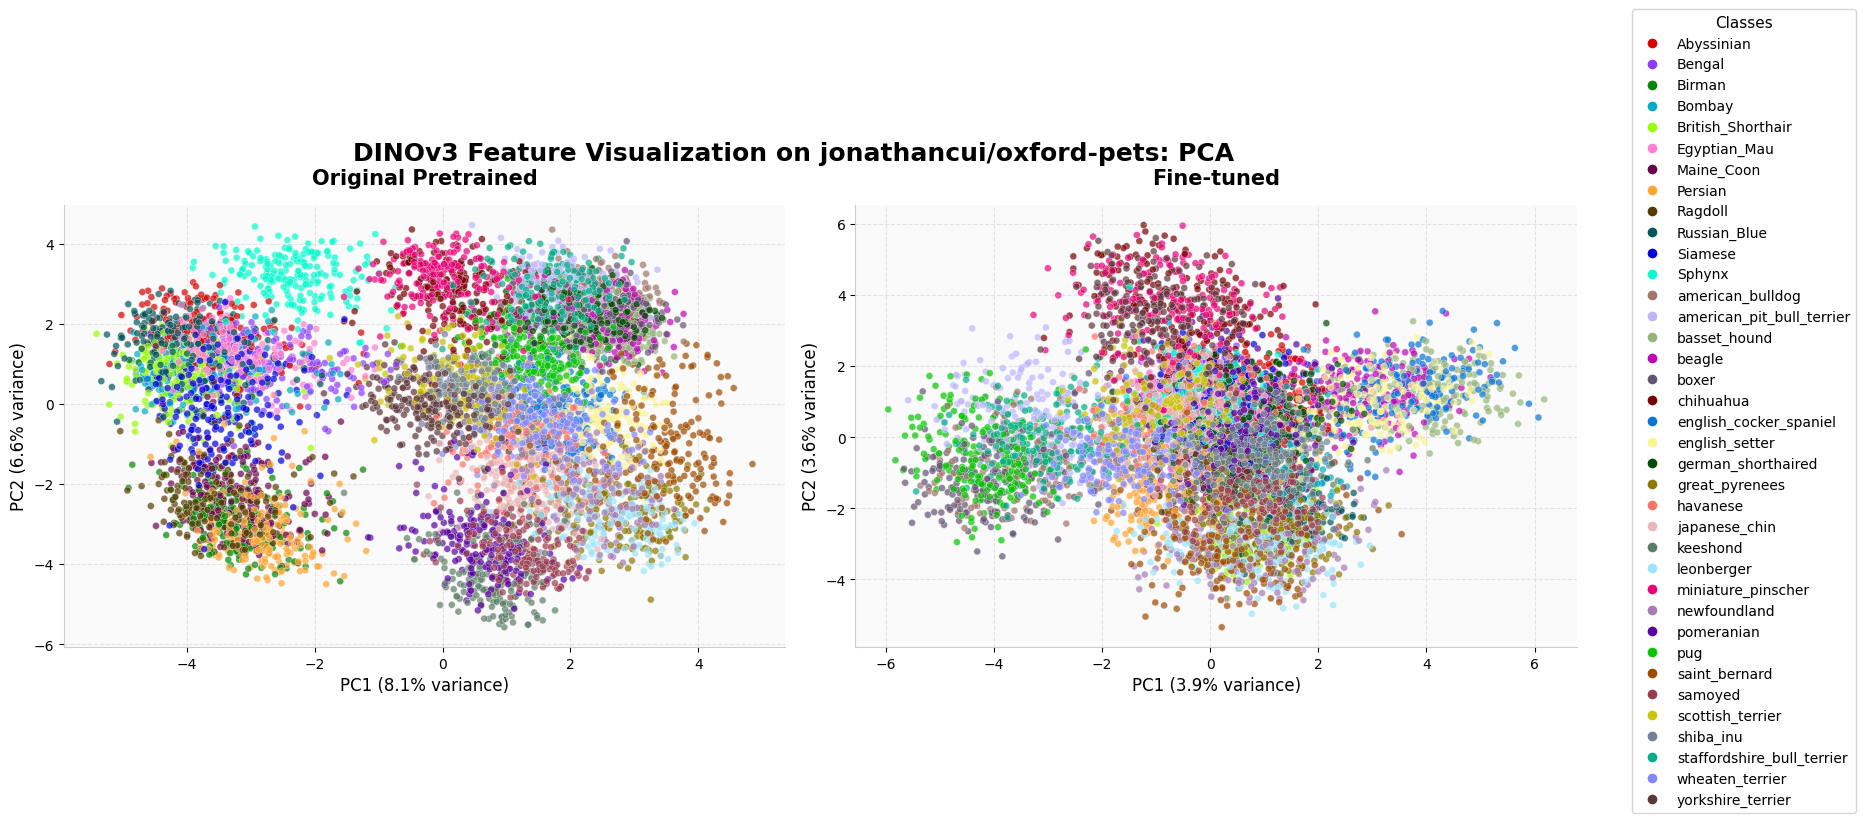

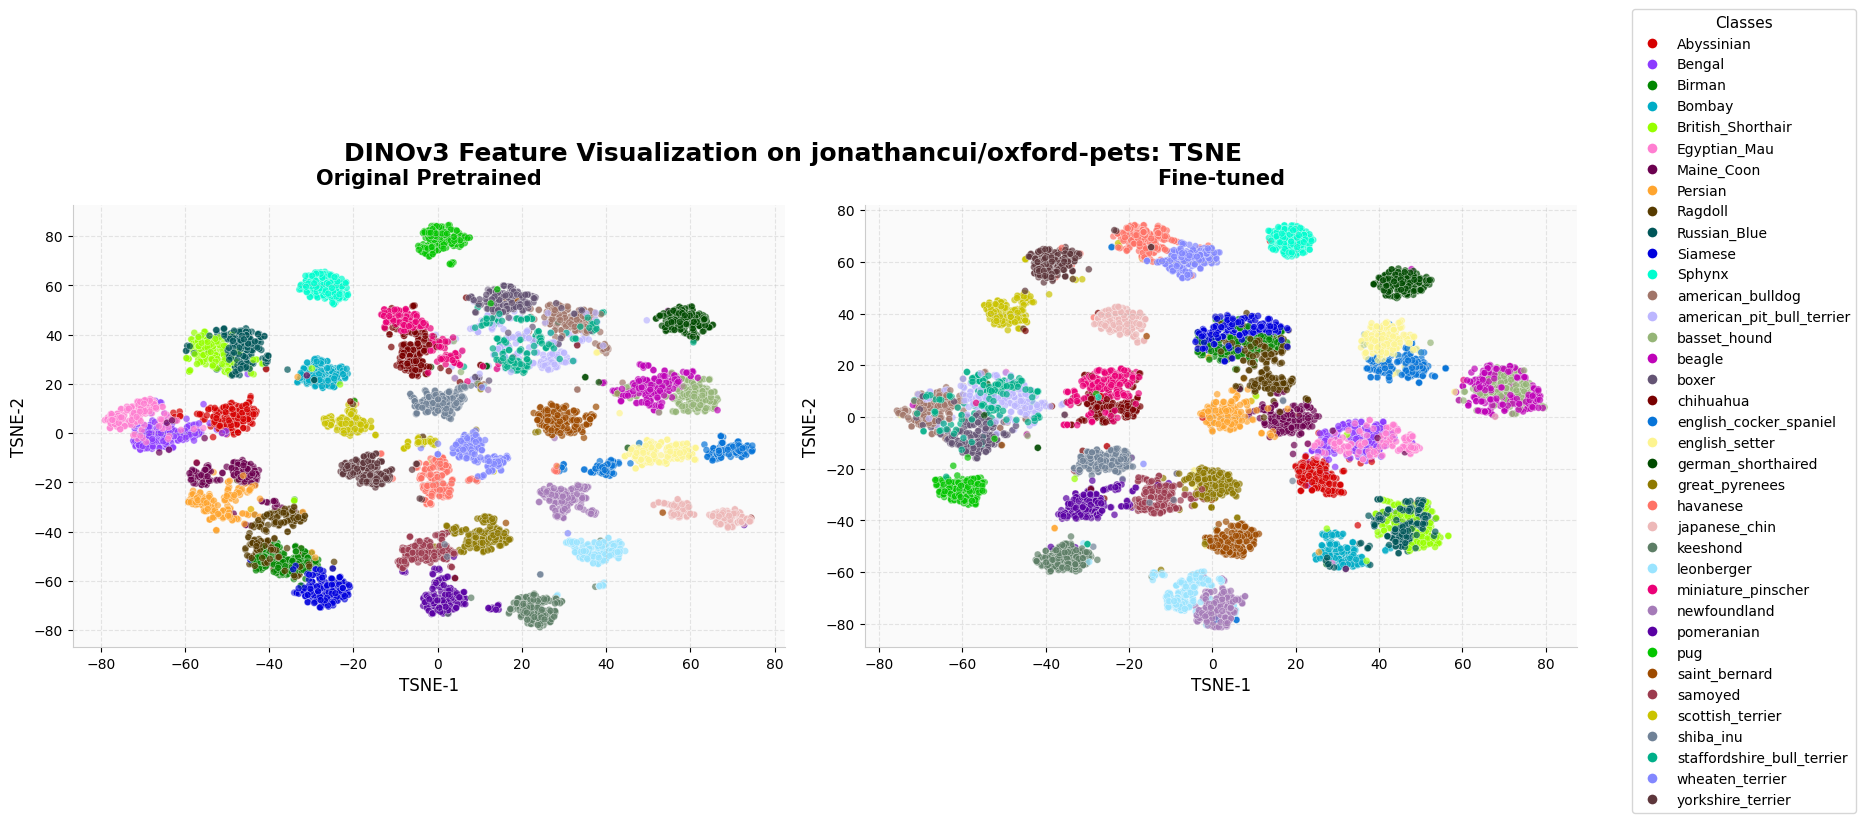

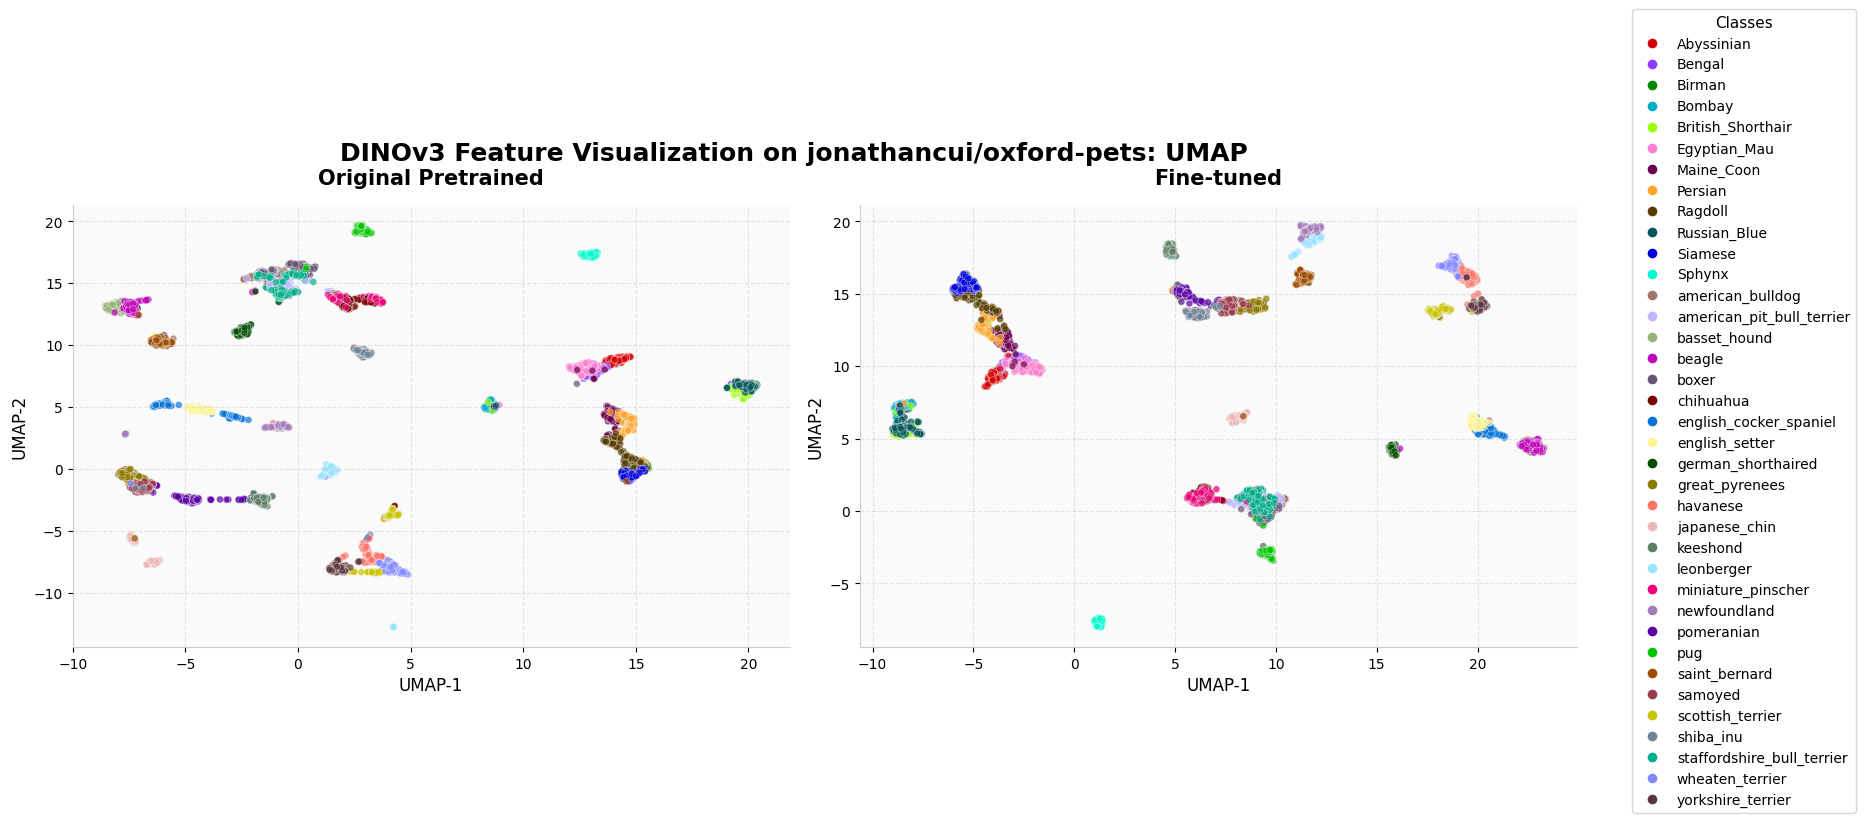

✓ Comparison visualizations completed


In [8]:
# Create comparison visualizations for each method
print("=" * 60)
print("VISUALIZATION")
print("=" * 60)

methods = ['pca', 'tsne', 'umap']

for method in methods:
    method_embeddings = {}
    for name in embeddings.keys():
        if method in embeddings[name]:
            method_embeddings[name] = embeddings[name][method]
    
    if method_embeddings:
        exp_var = explained_variance if method == 'pca' else None
        plot_comparison(method_embeddings, method, exp_var)

print("✓ Comparison visualizations completed")

FEATURE DISTRIBUTION ANALYSIS


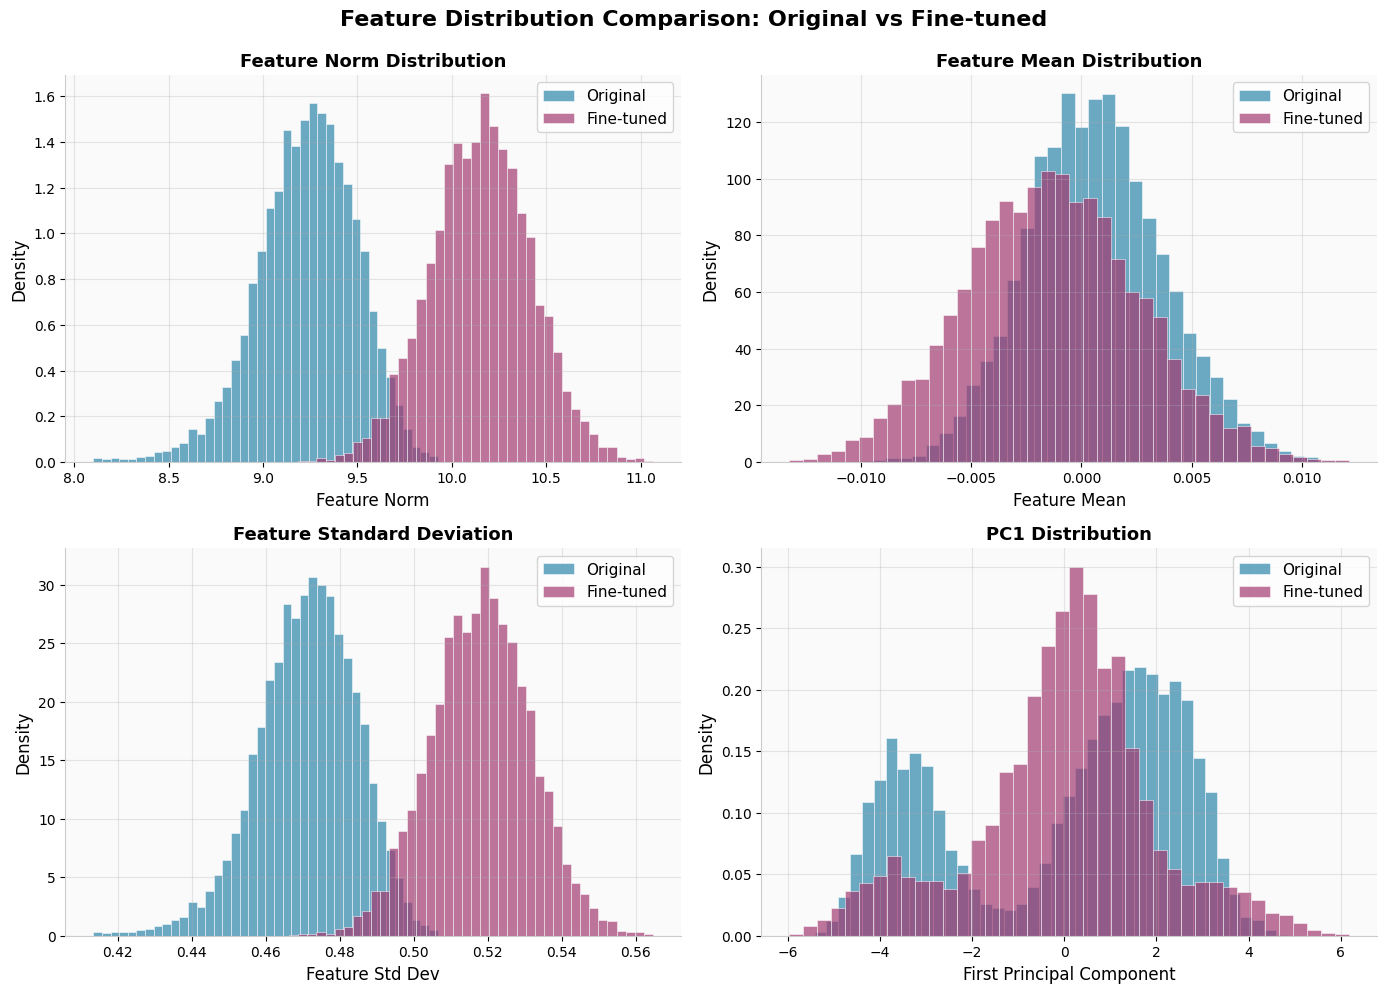

✓ Feature distribution analysis completed


In [9]:
# Feature distribution analysis
print("=" * 60)  
print("FEATURE DISTRIBUTION ANALYSIS")
print("=" * 60)

if features:
    plot_feature_distributions()
    print("✓ Feature distribution analysis completed")
else:
    print("✗ No features available for distribution analysis")

## 🔬 Feature Similarity Analysis

FEATURE SIMILARITY ANALYSIS
Computing pairwise similarities for 500 samples...


Computing similarities: 100%|██████████| 500/500 [00:00<00:00, 4015.67it/s]


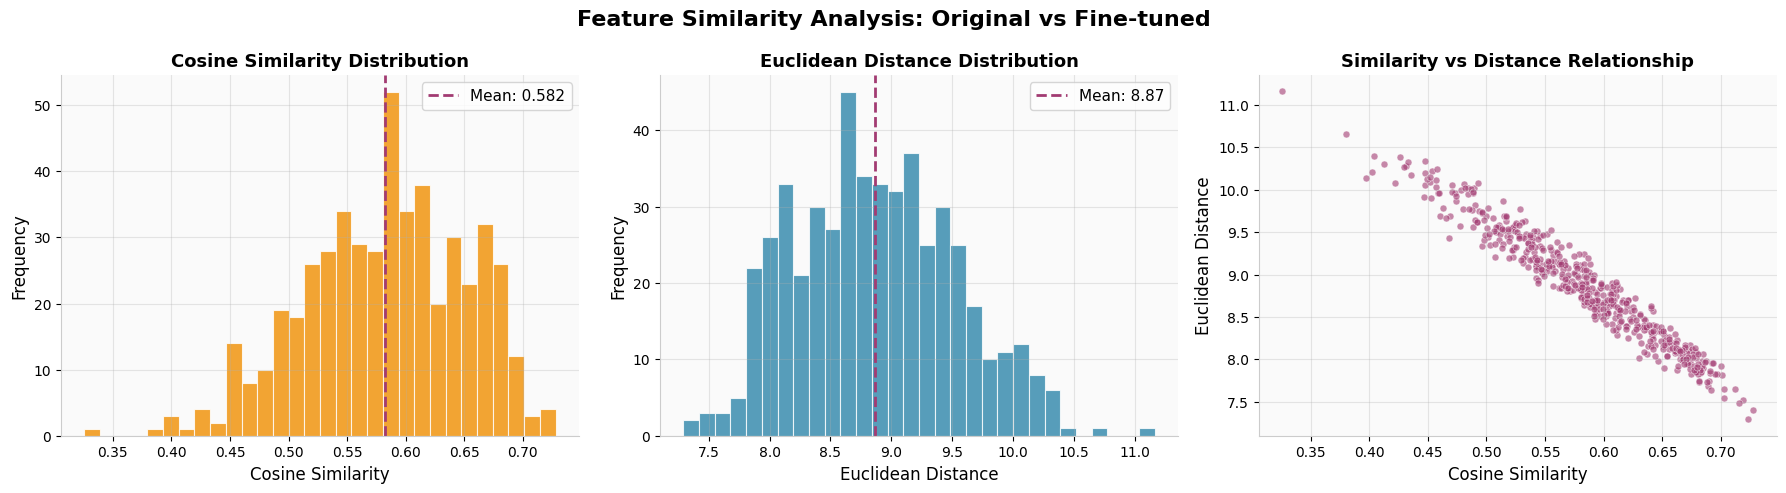


📊 Similarity Analysis Summary:
   Cosine Similarity: 0.5819 ± 0.0688
   Range: [0.3258, 0.7279]
   Euclidean Distance: 8.8691 ± 0.6608
   Range: [7.2919, 11.1634]
✓ Similarity analysis completed


In [10]:
# Feature Similarity Analysis
print("=" * 60)
print("FEATURE SIMILARITY ANALYSIS") 
print("=" * 60)

def analyze_similarity():
    """Analyze similarity between original and fine-tuned features"""
    if len(features) < 2:
        print("✗ Need both original and fine-tuned features for similarity analysis")
        return
        
    original_feats = features['original']
    finetuned_feats = features['finetuned']
    
    # Sample subset for computational efficiency
    n_samples = min(500, len(original_feats))
    indices = np.random.choice(len(original_feats), n_samples, replace=False)
    
    orig_sample = original_feats[indices]
    finetuned_sample = finetuned_feats[indices]
    
    # Calculate similarities
    cosine_sims = []
    euclidean_dists = []
    
    print(f"Computing pairwise similarities for {n_samples} samples...")
    for i in tqdm(range(n_samples), desc="Computing similarities"):
        # Cosine similarity
        cos_sim = cosine_similarity([orig_sample[i]], [finetuned_sample[i]])[0,0]
        cosine_sims.append(cos_sim)
        
        # Euclidean distance
        eucl_dist = np.linalg.norm(orig_sample[i] - finetuned_sample[i])
        euclidean_dists.append(eucl_dist)
    
    cosine_sims = np.array(cosine_sims)
    euclidean_dists = np.array(euclidean_dists)
    
    # Create similarity analysis plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Feature Similarity Analysis: Original vs Fine-tuned', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Cosine similarity distribution
    ax = axes[0]
    ax.hist(cosine_sims, bins=30, alpha=0.8, color=COLORS['accent'], 
            edgecolor='white', linewidth=0.8)
    ax.axvline(np.mean(cosine_sims), color=COLORS['finetuned'], linestyle='--', 
               linewidth=2, label=f'Mean: {np.mean(cosine_sims):.3f}')
    ax.set_xlabel('Cosine Similarity', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Cosine Similarity Distribution', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#fafafa')
    
    # Euclidean distance distribution
    ax = axes[1]
    ax.hist(euclidean_dists, bins=30, alpha=0.8, color=COLORS['original'],
            edgecolor='white', linewidth=0.8)
    ax.axvline(np.mean(euclidean_dists), color=COLORS['finetuned'], linestyle='--', 
               linewidth=2, label=f'Mean: {np.mean(euclidean_dists):.2f}')
    ax.set_xlabel('Euclidean Distance', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Euclidean Distance Distribution', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#fafafa')
    
    # Scatter plot: similarity vs distance  
    ax = axes[2]
    scatter = ax.scatter(cosine_sims, euclidean_dists, 
                        alpha=0.6, s=25, c=COLORS['finetuned'],
                        edgecolors='white', linewidth=0.5)
    ax.set_xlabel('Cosine Similarity', fontsize=12)
    ax.set_ylabel('Euclidean Distance', fontsize=12)
    ax.set_title('Similarity vs Distance Relationship', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#fafafa')
    
    # Style all axes
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#cccccc')
        ax.spines['bottom'].set_color('#cccccc')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'feature_similarity_analysis.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 Similarity Analysis Summary:")
    print(f"   Cosine Similarity: {np.mean(cosine_sims):.4f} ± {np.std(cosine_sims):.4f}")
    print(f"   Range: [{np.min(cosine_sims):.4f}, {np.max(cosine_sims):.4f}]")
    print(f"   Euclidean Distance: {np.mean(euclidean_dists):.4f} ± {np.std(euclidean_dists):.4f}")
    print(f"   Range: [{np.min(euclidean_dists):.4f}, {np.max(euclidean_dists):.4f}]")
    
    return cosine_sims, euclidean_dists

if 'original' in features and 'finetuned' in features:
    similarity_results = analyze_similarity()
    print("✓ Similarity analysis completed")
else:
    print("✗ Both original and fine-tuned features needed for similarity analysis")

## 💾 Save Results and Summary

In [11]:
# Save Results and Summary
print("=" * 60)
print("SAVING RESULTS")
print("=" * 60)

def save_analysis_results():
    """Save all analysis results to files"""
    
    # Save feature arrays
    for name, feats in features.items():
        np.save(OUTPUT_DIR / f'{name}_features.npy', feats)
        print(f"✓ Saved {name} features: {feats.shape}")
    
    # Save embeddings
    for name, embeds in embeddings.items():
        for method, data in embeds.items():
            np.save(OUTPUT_DIR / f'{name}_{method}.npy', data)
            print(f"✓ Saved {name} {method}: {data.shape}")
    
    # Create comprehensive summary
    summary = {
        'analysis_info': {
            'dataset_type': DATASET_TYPE,
            'dataset_name': dataset_name,
            'num_samples': len(dataset),
            'max_samples': MAX_SAMPLES,
            'batch_size': BATCH_SIZE,
            'random_seed': RANDOM_SEED
        },
        'dataset_config': {
            'custom_path': CUSTOM_DATASET_PATH if DATASET_TYPE == 'custom' else None,
            'hf_name': HF_DATASET_NAME if DATASET_TYPE == 'huggingface' else None,
            'hf_split': HF_SPLIT if DATASET_TYPE == 'huggingface' else None
        },
        'models': {
            'original_path': ORIGINAL_MODEL_PATH,
            'finetuned_path': FINETUNED_CHECKPOINT,
            'models_loaded': models_loaded
        },
        'feature_statistics': stats,
        'dimensionality_reduction': {
            'pca_components': PCA_COMPONENTS,
            'tsne_perplexity': TSNE_PERPLEXITY,
            'umap_neighbors': UMAP_NEIGHBORS
        },
        'explained_variance': {name: var.tolist() for name, var in explained_variance.items()}
    }
    
    # Add similarity results if available
    if 'original' in features and 'finetuned' in features:
        if 'similarity_results' in locals():
            cosine_sims, euclidean_dists = similarity_results
            summary['similarity_analysis'] = {
                'cosine_similarity_mean': float(np.mean(cosine_sims)),
                'cosine_similarity_std': float(np.std(cosine_sims)),
                'euclidean_distance_mean': float(np.mean(euclidean_dists)),
                'euclidean_distance_std': float(np.std(euclidean_dists))
            }
    
    # Save summary as JSON
    import json
    with open(OUTPUT_DIR / 'analysis_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    print("✓ Saved analysis summary")
    
    # List all generated files
    print(f"\n📁 Generated files in {OUTPUT_DIR}:")
    for file in sorted(OUTPUT_DIR.glob('*')):
        print(f"   • {file.name}")
    
    return summary

# Save results
if features:
    analysis_summary = save_analysis_results()
    
    print(f"\n🎯 Analysis Summary:")
    print(f"   Dataset: {dataset_name} ({DATASET_TYPE})")
    print(f"   Models analyzed: {list(features.keys())}")
    print(f"   Feature dimension: {list(features.values())[0].shape[1]}")
    print(f"   Samples processed: {list(features.values())[0].shape[0]}")
    
    if 'original' in features and 'finetuned' in features:
        print(f"   ✓ Comparative analysis completed")
    else:
        print(f"   ⚠ Single model analysis (missing comparison)")
        
    print(f"   Visualizations: PCA, t-SNE, UMAP comparisons")
    print(f"   📊 Results saved to: {OUTPUT_DIR}")
    
else:
    print("✗ No features extracted - cannot save results")

SAVING RESULTS
✓ Saved original features: (7349, 384)
✓ Saved finetuned features: (7349, 384)
✓ Saved original pca: (7349, 50)
✓ Saved original tsne: (7349, 2)
✓ Saved original umap: (7349, 2)
✓ Saved finetuned pca: (7349, 50)
✓ Saved finetuned tsne: (7349, 2)
✓ Saved finetuned umap: (7349, 2)
✓ Saved analysis summary

📁 Generated files in feature_analysis_unified_results:
   • analysis_summary.json
   • feature_distributions.png
   • feature_similarity_analysis.png
   • finetuned_features.npy
   • finetuned_pca.npy
   • finetuned_tsne.npy
   • finetuned_umap.npy
   • original_features.npy
   • original_pca.npy
   • original_tsne.npy
   • original_umap.npy
   • pca_comparison.png
   • tsne_comparison.png
   • umap_comparison.png

🎯 Analysis Summary:
   Dataset: jonathancui/oxford-pets (huggingface)
   Models analyzed: ['original', 'finetuned']
   Feature dimension: 384
   Samples processed: 7349
   ✓ Comparative analysis completed
   Visualizations: PCA, t-SNE, UMAP comparisons
   📊 Re

## 🎯 Analysis Summary

### 🔬 DINOv3 Unified Feature Analysis

This notebook provides a **flexible and comprehensive** framework for DINOv3 feature extraction and analysis:

#### ✨ **Key Features:**
- **🔄 Multi-Dataset Support**: Works with both Custom and HuggingFace datasets
- **⚖️ Dual Model Comparison**: Original pretrained vs fine-tuned models  
- **📊 Comprehensive Analysis**: PCA, t-SNE, UMAP visualizations
- **📈 Statistical Comparisons**: Feature distributions and similarity metrics
- **🎨 Professional Visualizations**: Publication-quality plots with custom styling
- **⚙️ Easy Configuration**: Simple dataset type switching

#### 🚀 **Usage:**
1. **Configure Dataset**: Set `DATASET_TYPE` to `"custom"` or `"huggingface"`
2. **Set Paths**: Configure dataset paths and model checkpoints
3. **Run Analysis**: Execute all cells for complete feature analysis
4. **Review Results**: Visualizations and summaries automatically generated

#### 📁 **Outputs:**
- **Feature Arrays**: Raw extracted features for both models
- **Embeddings**: PCA, t-SNE, UMAP coordinates for visualization
- **Comparison Plots**: Side-by-side model feature space comparisons
- **Distribution Analysis**: Statistical feature comparisons
- **Similarity Metrics**: Quantitative feature relationship analysis
- **JSON Summary**: Complete analysis metadata and statistics

#### 🎨 **Visualizations:**
- **Smart Coloring**: Automatic color mapping based on dataset type
- **Professional Styling**: Clean, publication-ready plots
- **Flexible Legends**: Automatic legend generation with readability limits
- **High Resolution**: 300 DPI output for presentations and papers

#### 💡 **Next Steps:**
- Modify `DATASET_TYPE` and paths for your specific datasets
- Adjust `MAX_SAMPLES` based on computational resources
- Customize color schemes and plot parameters as needed
- Use saved features and embeddings for downstream analysis

**This unified notebook replaces the need for separate custom and HuggingFace analysis notebooks!** 🎉